# Neural Data Science with Python - Day 2
* https://www.meetup.com/brain-and-consciousness/events/276875199/
![](images/meetupgroup.png)

* Today: Chapters 4-5 : Correlating spike trains, analog signals
* Next time (April 3?): Chapters 5-6 : Finish analog signals, Biophysical modeling (including custom classes in python)
* Final session (April 19?): Chapters 7-9 : Regression, Dimensionality Reduction, Classification

# Python examples from book: "Neural Data Science" by Erik Nylen and Pascal Wallisch
* https://www.amazon.com/gp/product/B06XCW39WX
* Datasets from book (and Jupyter notebooks for Python 2) at: https://www.elsevier.com/books-and-journals/book-companion/9780128040430/chapter-files#Chapter%20Files
![](images/BookCover.jpg)

# Additional resources
* Open-access neuroscience textbook: https://nba.uth.tmc.edu/neuroscience/s1/introduction.html
* Open-access 3-week computational neuroscience course: https://www.neuromatchacademy.org/syllabus

# Chapter 4: Correlating Spike Trains

## Theoretical overview:
### Examples focus on visual system. However, most sensory systems share this sequence of processing steps:

<b> Step 1: Transduction - Physical energy from environment is collected by sensory structures (usually involving groups of neurons with specialized proteins). </b>

For example, the retina's photoreceptor cells contain photoreceptor proteins that absorb a limited range of wavelengths.
* https://courses.lumenlearning.com/wm-biology2/chapter/transduction-of-light/ 
  * (Images used in accordance with CC license: https://creativecommons.org/licenses/by/4.0/) 

![](images/transduction_1.png)
![](images/transduction_3.png)

A metabolic cascade closes ion channels, kicking off a chain of neural transmission.
* https://en.wikipedia.org/wiki/Visual_phototransduction
  * (Image used in accordance with CC license: https://creativecommons.org/licenses/by/3.0/) 
  * Jason J. Corneveaux, wiki user: Caddymob (talk) - http://en.wikipedia.org/wiki/File:Phototransduction.png

![](images/transduction_2.png)
From book:
![](images/transduction_4.png)

<b> Step 2: Filtering - Initial pre-processing for low-level features such as fast motion or high-contrast edges. </b>

Handled in the brain by the thalamus, which serves as a routing hub for many types of sensory signals and high-level neural signals. 

Interestingly, the low-level features identified by thalamic processing are forwarded to the amygdala to initiate defensive reactions to obvious threats (such as flinching away from something flying at your face).

* image from LeDoux 1994

<img src="images/filtering_1_ledoux1994.png" width="700">

<b> Step 3: Formatting - Extraction of categorical features. </b>

Example: V1 neurons differentially encode horizontal bars versus vertical bars. Animals tend to process horizontal and vertical bars more saliently than diagonals.

<b> Step 4: Computations - Information streams diverge into parallel pathways for higher order processing. </b>

Example: Low-level visual signals leaving V1 eventually diverge to a dorsal stream (spatial processing in parietal lobe) and a ventral stream (object recognition tied to memory in temporal lobe).

Fun fact: The brain's implementation of object recognition is still mysterious, but mounting evidence points to a process similar to convolutional neural networks.

<b> Step 5: Output - Behaviors or physiological adjustments that help the organism survive. </b>

##### Caveat: The boundaries between these steps can be blurry. 
* For example, some categories are created at transduction (step 1) by differential transduction mechanisms within a single sensory system.
  * Color is initially encoded in the retina by 3 different types of neurons that detect different wavelength ranges.
  * Different touch sensations (e.g. pressure, vibration, heat, cold) are initially generated by different kinds of sensory cells.


* In the defensive amygdala example, some thalamus-filtered signals (step 2) are forwarded directly to the amygdala for threat detection (step 3), and then passed immediately to output systems (step 5) before advanced parallel processing catches up (step 4). This is evolution's way of "playing it safe" with potentially life-ending stimuli.

#### Analogy to data science workflow

|Step|Biological|Example brain structure|Data Analysis Analogues|
|--- |--- ||--- |
|1|Transduction|Retina|Loading Data|
|2|Filtering|Thalamus|Filtering, Cleaning Data, "Quick and dirty" analysis|
|3|Formatting|V1|Category extraction, Univariate feature engineering, Serial computations|
|4|Computations|Diverging cortical pathways after V1|Parallel processing, Multivariate feature engineering|
|5|Output|Motor systems, Energy regulation systems|Output, Generating reports, Deploying models into production|

# Exercises from Chapter 4: Correlating Spike Trains

In [2]:
# Load packages and functions
import scipy.io
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sc

# Define constants for later
numChannels = 96
noiseCodes = [0, 255]
timeBase = np.arange(-0.2, 2.5, 0.01)
gratingOn = 0
gratingOff = 2

##### Data Collection method (extracellular recording)
![](images/ch4_6.png)

In [41]:
# Load data from matlab format
# Data downloaded from https://www.elsevier.com/books-and-journals/book-companion/9780128040430/chapter-files#Chapter%20Files
matIn = scipy.io.loadmat('./data/NDS Files for Download/arrayDATA.mat')

print('type:', type(matIn))
print('\n')
print(matIn.keys())
print('\n')
print('HEADER:\t', matIn['__header__'])
print('VERSION:', matIn['__version__'])
print('GLOBALS:', matIn['__globals__'])

type: <class 'dict'>


dict_keys(['__header__', '__version__', '__globals__', 'DATA'])


HEADER:	 b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Thu Jun 16 15:54:00 2016'
VERSION: 1.0
GLOBALS: []


## Pause to understand data structure of loaded data

In [52]:
# Examine data
# Numpy array shape is deceiving. More arrays are embedded in each field.
# Each trial contains 
print('type:', type(matIn['DATA']))
print('shape:', matIn['DATA'].shape)
print('There are', len(matIn['DATA']), 'trials')

type: <class 'numpy.ndarray'>
shape: (2300, 1)
There are 2300 trials


In [55]:
print(type( matIn['DATA'] ), matIn['DATA'].shape)
print(type( matIn['DATA'][0] ), matIn['DATA'][0].shape)
print(type( matIn['DATA'][0][0] ), matIn['DATA'][0][0].shape)
print(type( matIn['DATA'][0][0][0] ), matIn['DATA'][0][0][0].shape)

<class 'numpy.ndarray'> (2300, 1)
<class 'numpy.ndarray'> (1,)
<class 'numpy.void'> ()
<class 'numpy.ndarray'> (207, 3)


In [54]:
print(matIn['DATA'][0])

[(array([[ 20.   ,   1.   ,   0.624],
        [ 20.   ,   1.   ,   0.63 ],
        [ 20.   ,   3.   ,   0.652],
        [ 20.   ,   3.   ,   0.659],
        [ 20.   , 255.   ,   0.686],
        [ 20.   ,   1.   ,   0.689],
        [ 20.   ,   1.   ,   0.711],
        [ 20.   , 255.   ,   0.731],
        [ 20.   ,   3.   ,   0.742],
        [ 20.   ,   3.   ,   0.757],
        [ 20.   ,   2.   ,   0.764],
        [ 20.   ,   4.   ,   0.779],
        [ 20.   ,   2.   ,   0.786],
        [ 20.   ,   3.   ,   0.812],
        [ 20.   ,   1.   ,   0.826],
        [ 20.   ,   3.   ,   0.848],
        [ 20.   , 255.   ,   0.857],
        [ 20.   ,   4.   ,   0.866],
        [ 20.   ,   1.   ,   0.872],
        [ 20.   ,   3.   ,   0.883],
        [ 20.   ,   3.   ,   0.898],
        [ 20.   ,   4.   ,   0.909],
        [ 20.   , 255.   ,   0.926],
        [ 20.   ,   3.   ,   0.951],
        [ 20.   ,   1.   ,   0.968],
        [ 20.   , 255.   ,   0.981],
        [ 20.   , 255.   ,   0.992],


In [108]:
import pandas as pd
display( pd.DataFrame(matIn['DATA'][0][0][0], columns =['channel','sort cluster','spike time']).head() )

channel  sort cluster  spike time
0     20.0           1.0       0.624
1     20.0           1.0       0.630
2     20.0           3.0       0.652
3     20.0           3.0       0.659
4     20.0         255.0       0.686

## Back to exercises

In [59]:
# Determine several parameters that will be used in later analysis from the data itself,
# such as the number of trials, the grating orientation and number of grating orientations.

numTrials = len(matIn['DATA'])
allOris = [matIn['DATA'][_][0][1][0][0] for _ in range(numTrials)] # intermediate variable
ori = list(set(allOris))
numOri = len(ori)
trialIndices = defaultdict(list)

In [64]:
numTrials

2300

In [63]:
# Only 2 unique orientations
print(numOri, 'unique orientations:', ori)

2 unique orientations: [0.0, 90.0]


![](images/gratings.png)

##### Side note: Placing those gratings side-by-side trips out my visual system...

![](images/ch4_5.png)
##### We want to collect all spike times for a given orientation, channel, and trial

In [73]:
# Gather all trial indices for a given orientation

trialIndices = defaultdict(list) # Declare variable anew so it doesn't add to exist array upon re-running cell

for tt in range(numTrials):
    for oo in ori:
        if allOris[tt] == oo:
            trialIndices[oo].append(tt)

In [103]:
# Examine result
for oo in ori:
    print('orientation='+str(oo), 'has', len(trialIndices[oo]), 'trials')

orientation=0.0 has 1150 trials
orientation=90.0 has 1150 trials


In [104]:
max(trialIndices[0])

2299

In [105]:
# We want a list of spike times for each combination of orientation, channel, and trial

# This cell takes FOREVER to run
# Cell borrowed from publisher site: https://www.elsevier.com/books-and-journals/book-companion/9780128040430/chapter-files#Chapter%20Files

numOris = len(ori)
# Line declaring spikeTimes was not in book.
spikeTimes=[[[[] for _ in range(numChannels)] for __ in range(numOris)] for ___ in range(numTrials)]

for orind,oo in enumerate(ori): # Loop through all conditions (grating orientation types)
    for tt in trialIndices[oo]: # Loop through all trials of a given type
        for cc in range(numChannels): # Loop through all channels (electrodes)
            spikeTimes[tt][orind][cc] = [spike[2] for spike in matIn['DATA'][tt][0][0] if (spike[0]==cc) and (spike[1] not in noiseCodes)]

In [106]:
# Merging all trials for each given channel and orientation.

# Cell borrowed from publisher site: https://www.elsevier.com/books-and-journals/book-companion/9780128040430/chapter-files#Chapter%20Files

linearizedSpikeTimes = defaultdict(lambda: defaultdict(list))
for eachtrial in matIn["DATA"]: # Loop over all trials
    stimori = eachtrial[0][1][0][0]
    for eachspike in eachtrial[0][0]:
        if eachspike[1] not in [0,255]: # if the value is good
            trode = eachspike[0] # Loop over all channels
            spikeTimes = eachspike[2]
            linearizedSpikeTimes[trode][stimori].append(spikeTimes)

### PSTH (Peri-stimulus time histogram)

In [142]:
# Cell borrowed from publisher site: https://www.elsevier.com/books-and-journals/book-companion/9780128040430/chapter-files#Chapter%20Files

PSTHs = defaultdict(lambda: defaultdict(list))
for unitkey in linearizedSpikeTimes.keys():
    PSTHs[unitkey][0],bins = np.histogram(linearizedSpikeTimes[unitkey][0], bins=timeBase)
    PSTHs[unitkey][90],bins = np.histogram(linearizedSpikeTimes[unitkey][90], bins=timeBase)

<ipython-input-143-8d6c3e575c50>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig=plt.figure(facecolor='w')


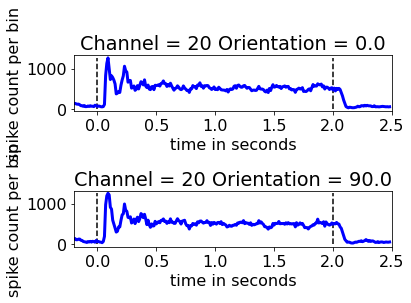

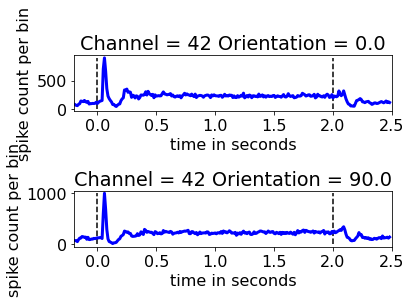

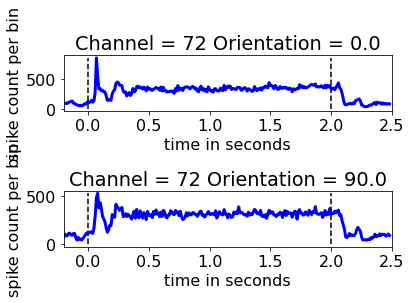

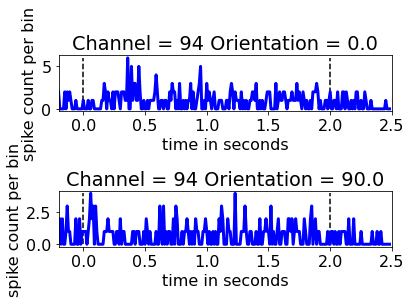

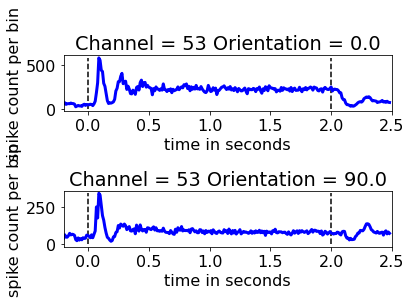

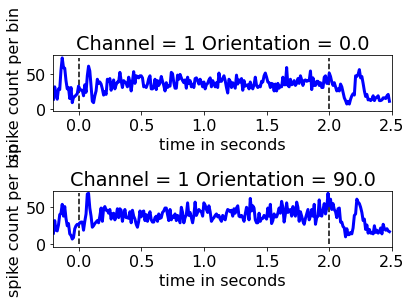

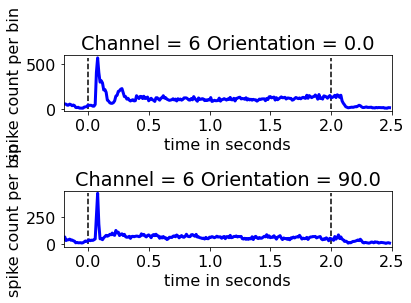

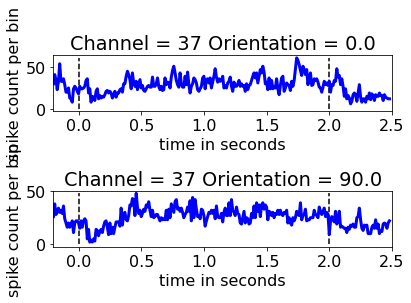

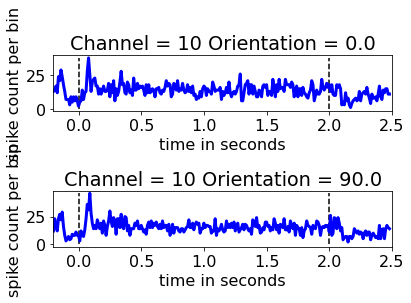

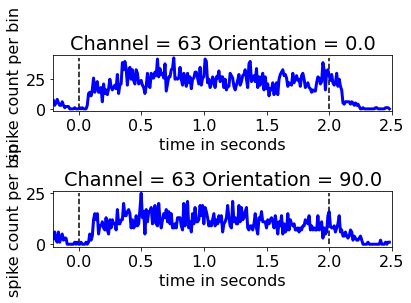

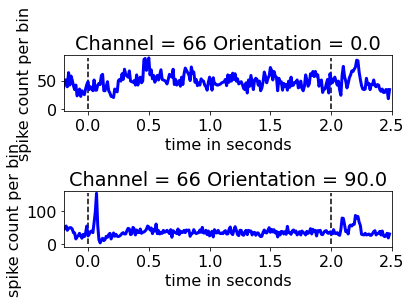

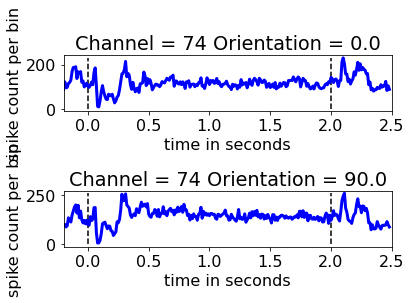

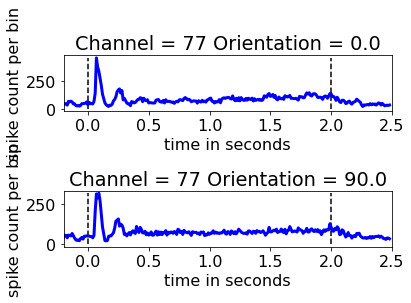

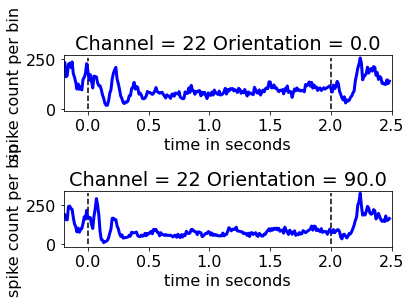

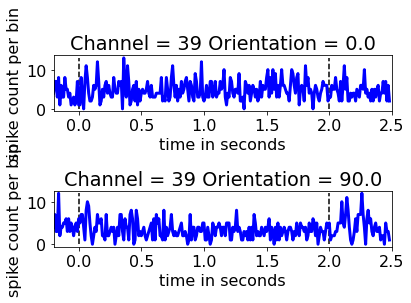

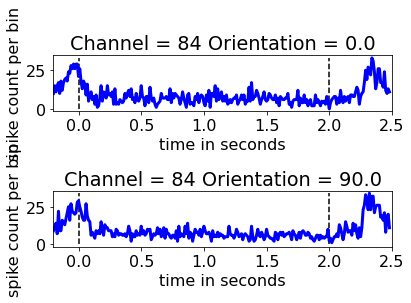

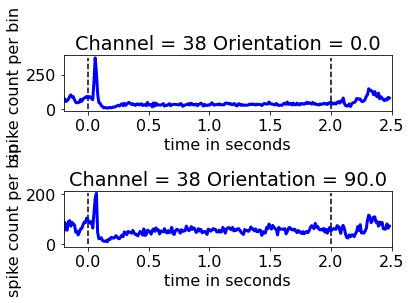

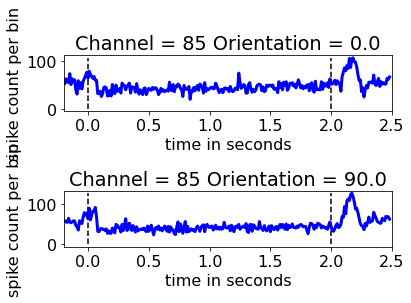

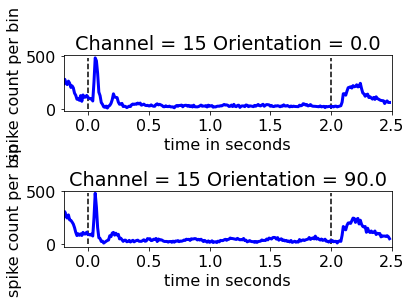

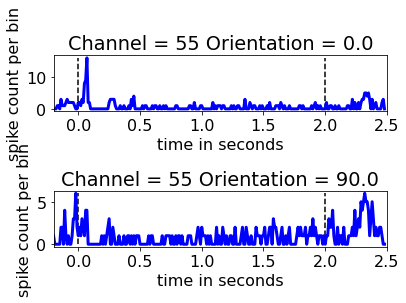

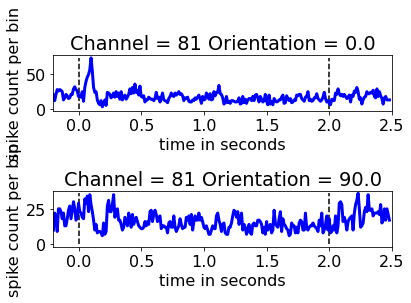

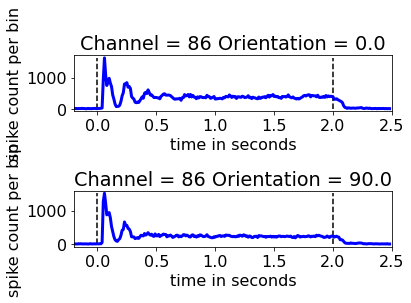

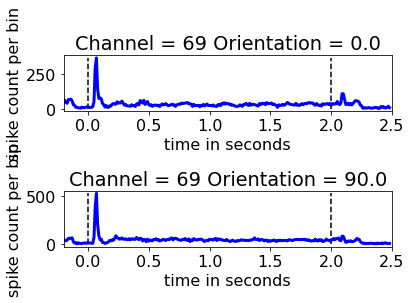

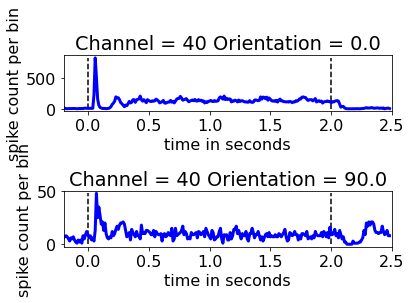

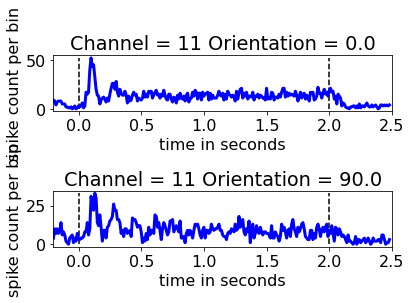

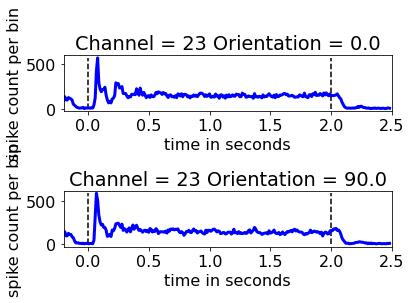

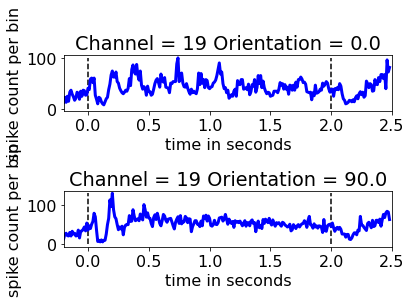

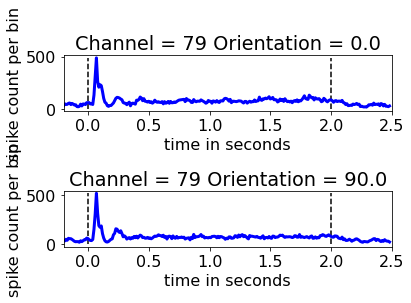

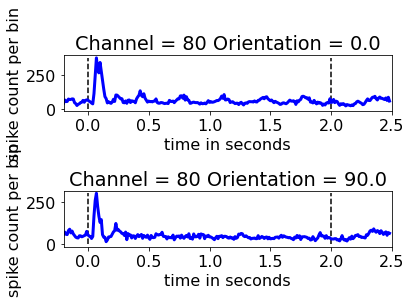

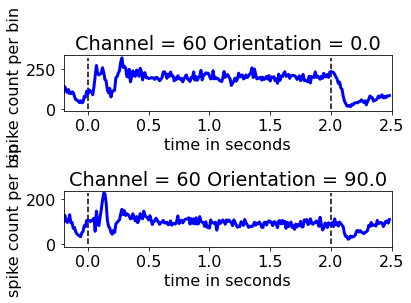

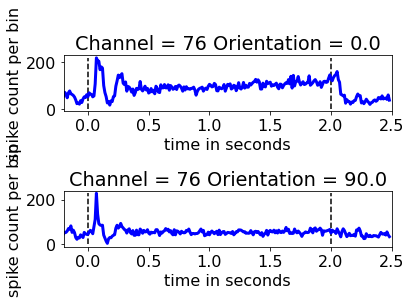

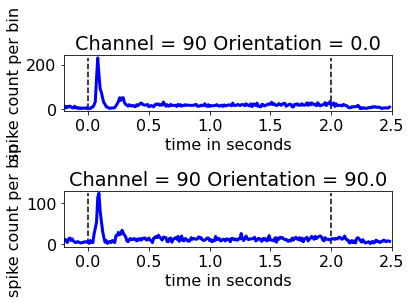

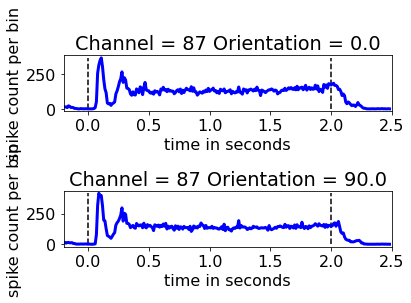

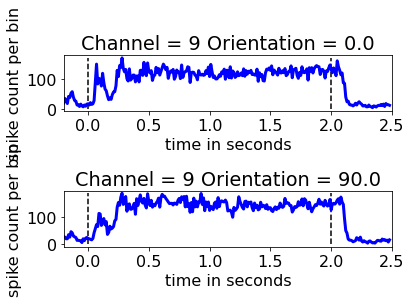

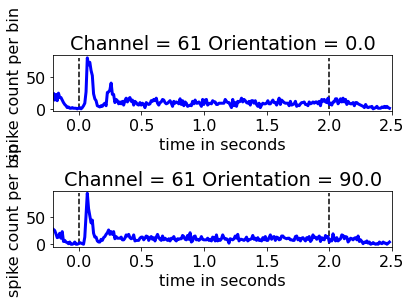

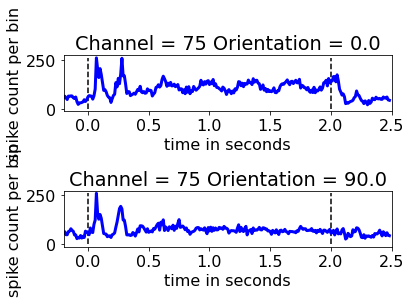

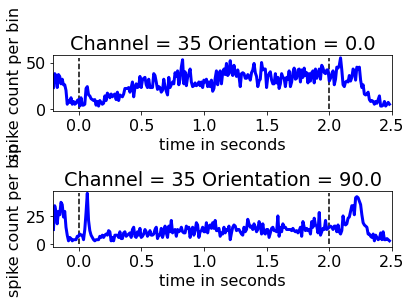

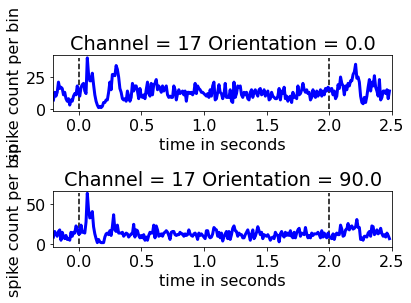

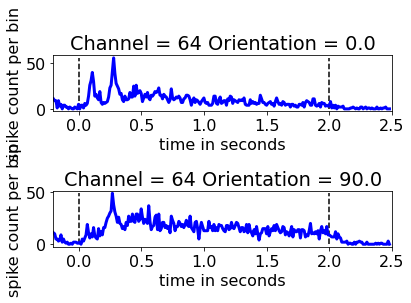

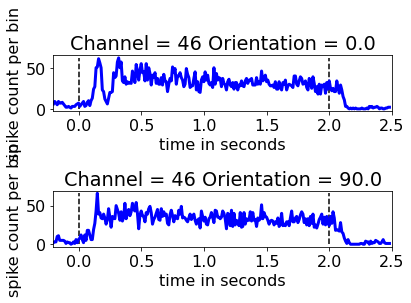

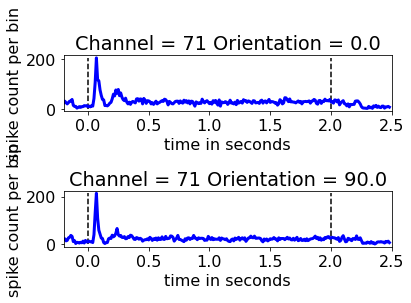

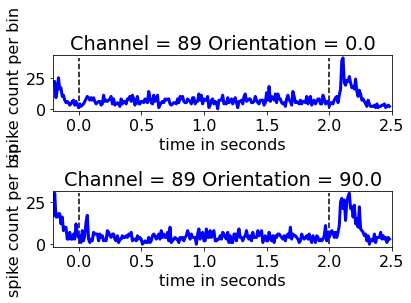

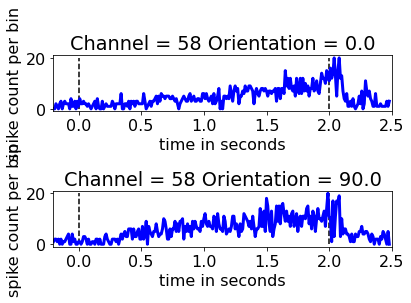

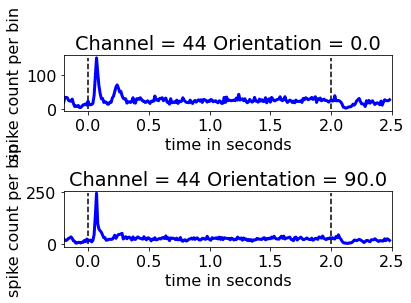

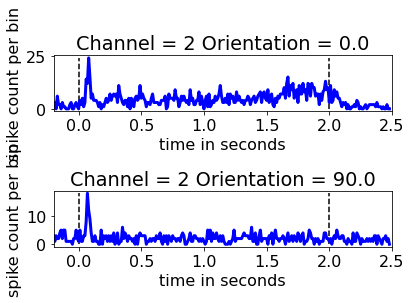

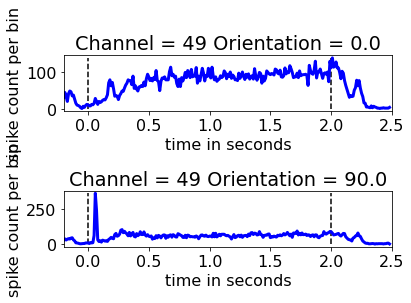

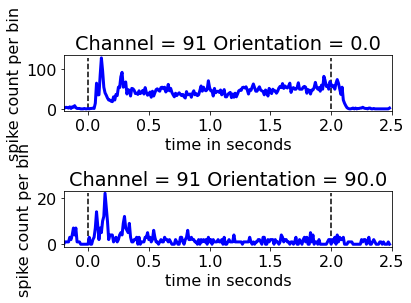

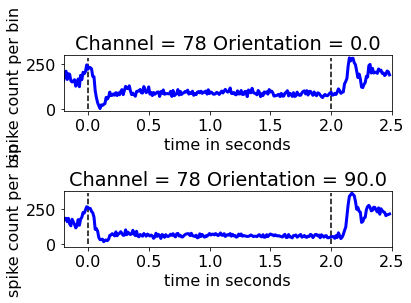

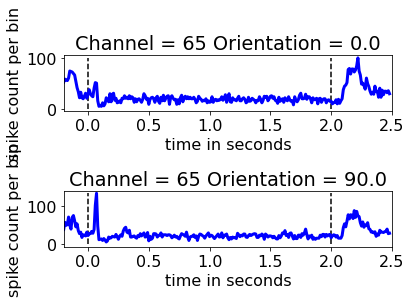

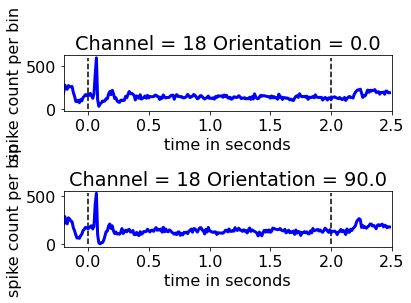

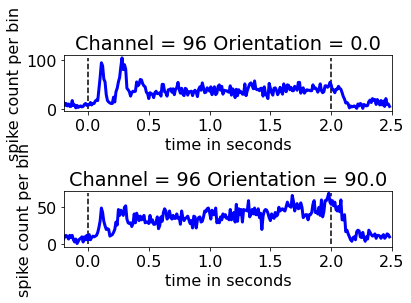

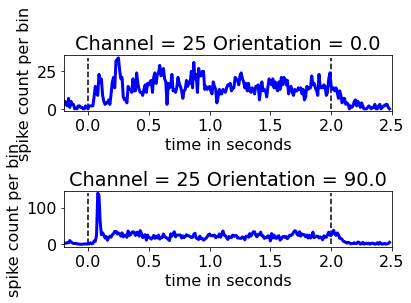

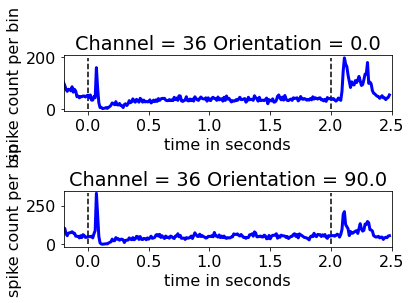

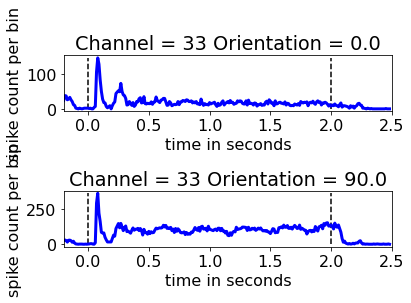

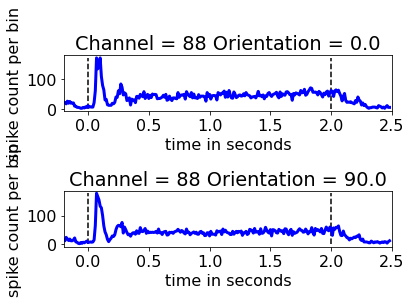

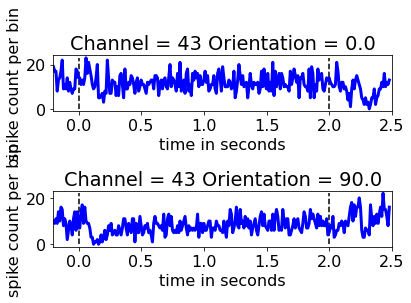

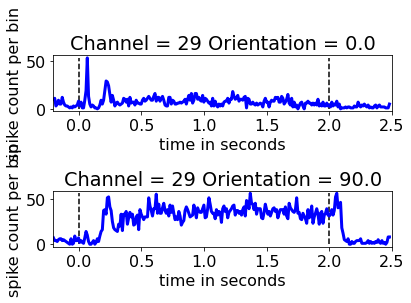

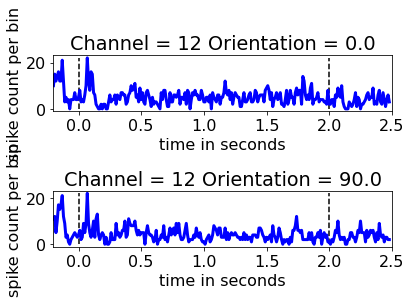

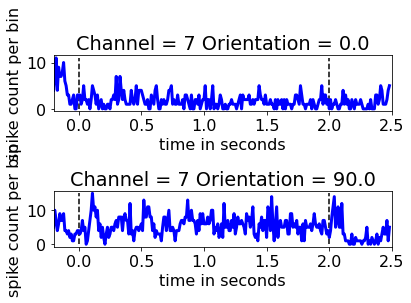

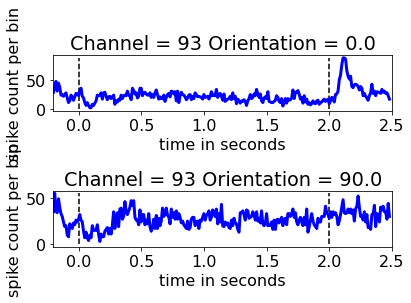

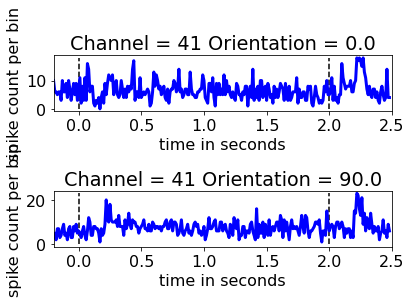

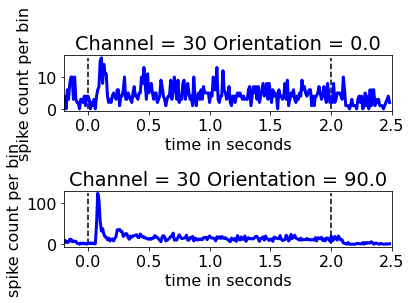

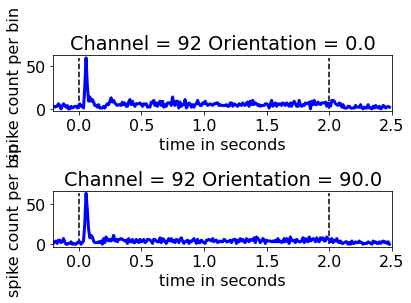

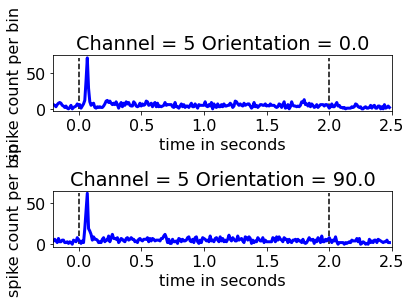

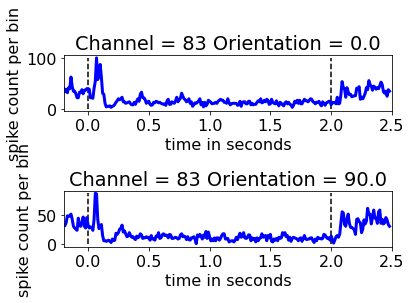

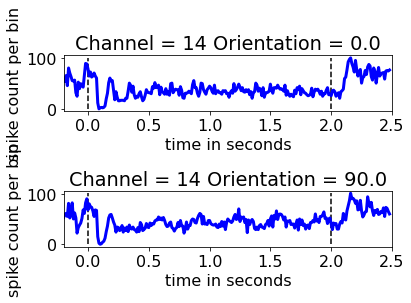

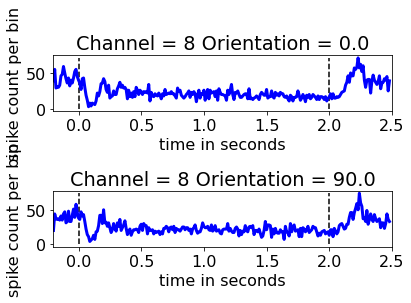

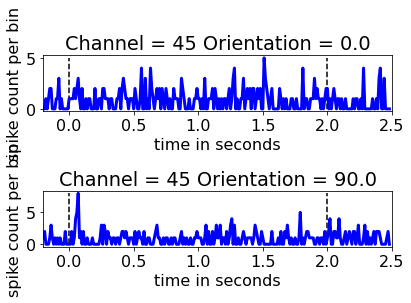

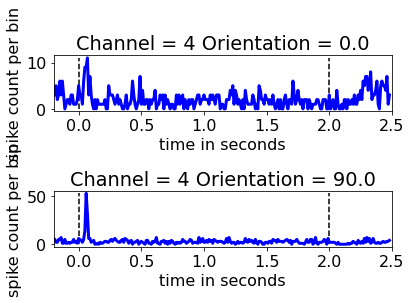

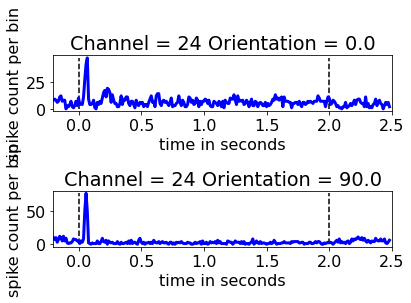

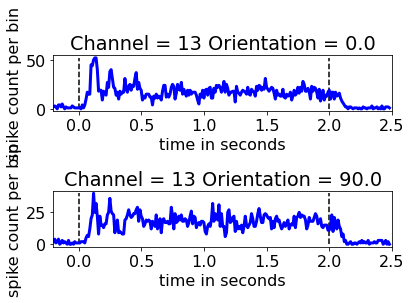

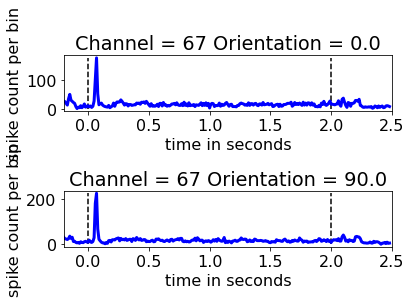

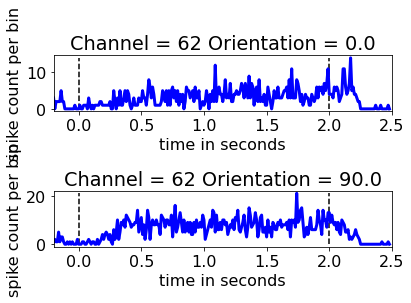

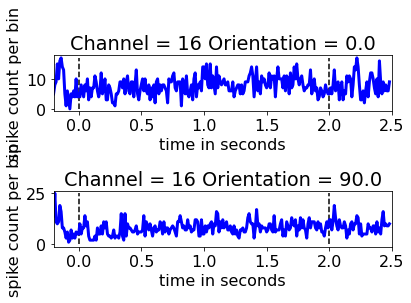

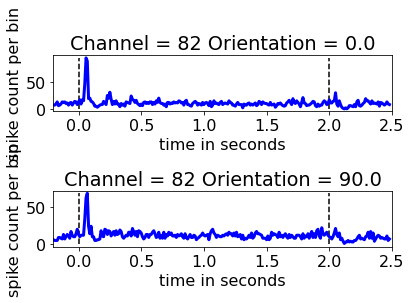

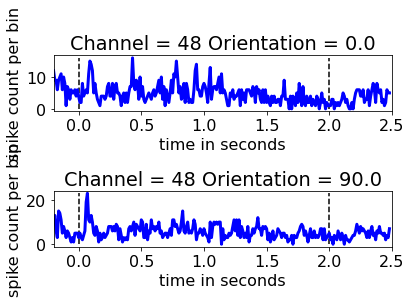

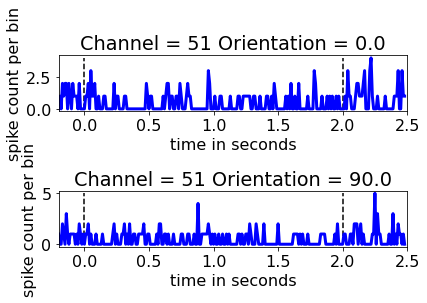

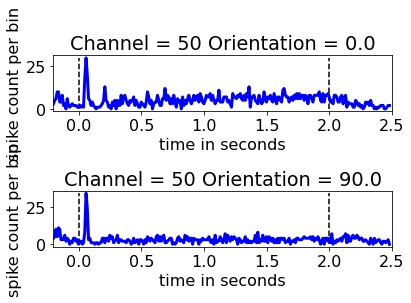

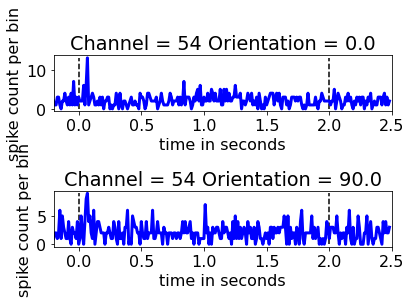

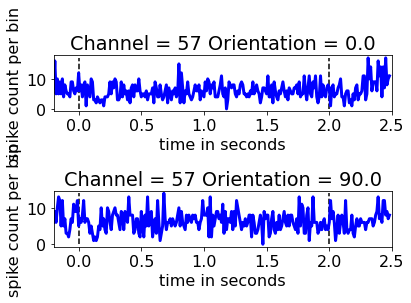

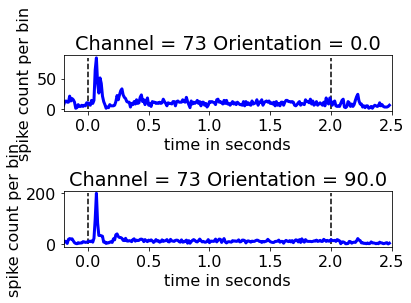

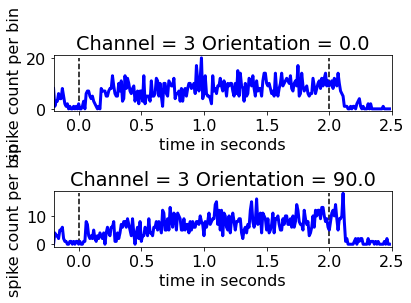

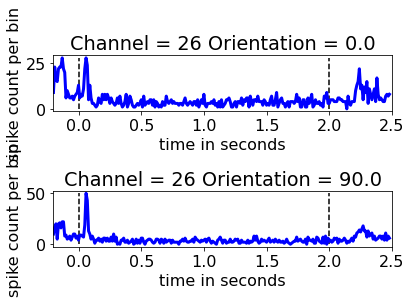

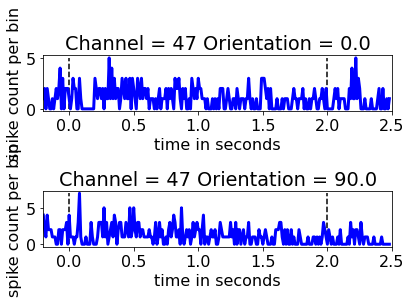

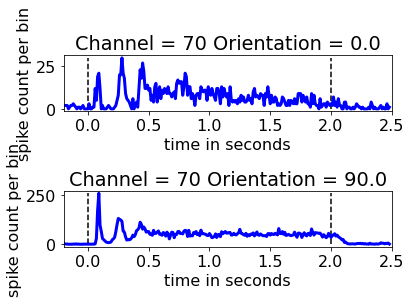

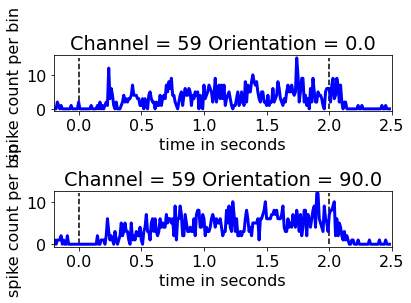

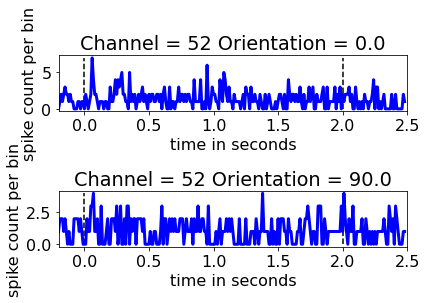

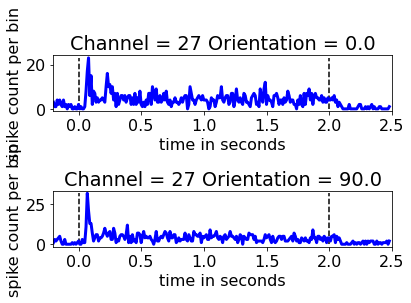

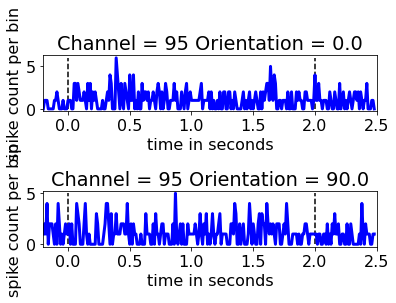

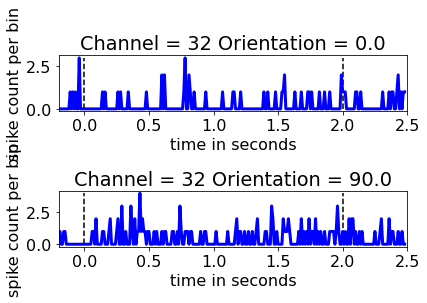

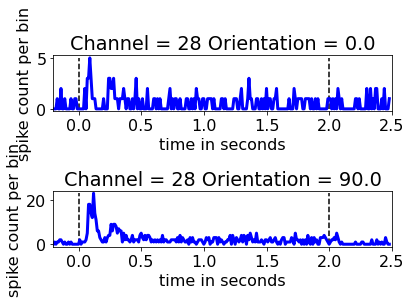

In [143]:
# Cell borrowed from publisher site: https://www.elsevier.com/books-and-journals/book-companion/9780128040430/chapter-files#Chapter%20Files

for unitkey in PSTHs.keys():
    fig=plt.figure(facecolor='w')
    for orind,oo in enumerate(ori):
        ax = fig.add_subplot(2,1,orind+1)
        ax.plot(timeBase[:-1],PSTHs[unitkey][oo],lw=3,color='b')
        ax.set_xlim([-.2,2.5])
        ax.vlines(gratingOn,0,max(PSTHs[unitkey][oo]),color='k',linestyle='--')
        ax.vlines(gratingOff,0,max(PSTHs[unitkey][oo]),color='k',linestyle='--')
        ax.set_ylabel('spike count per bin')
        ax.set_xlabel('time in seconds')
        ax.set_title('Channel = '+str(int(unitkey))+' Orientation = '+str(oo))
    plt.tight_layout()
    #plt.show()

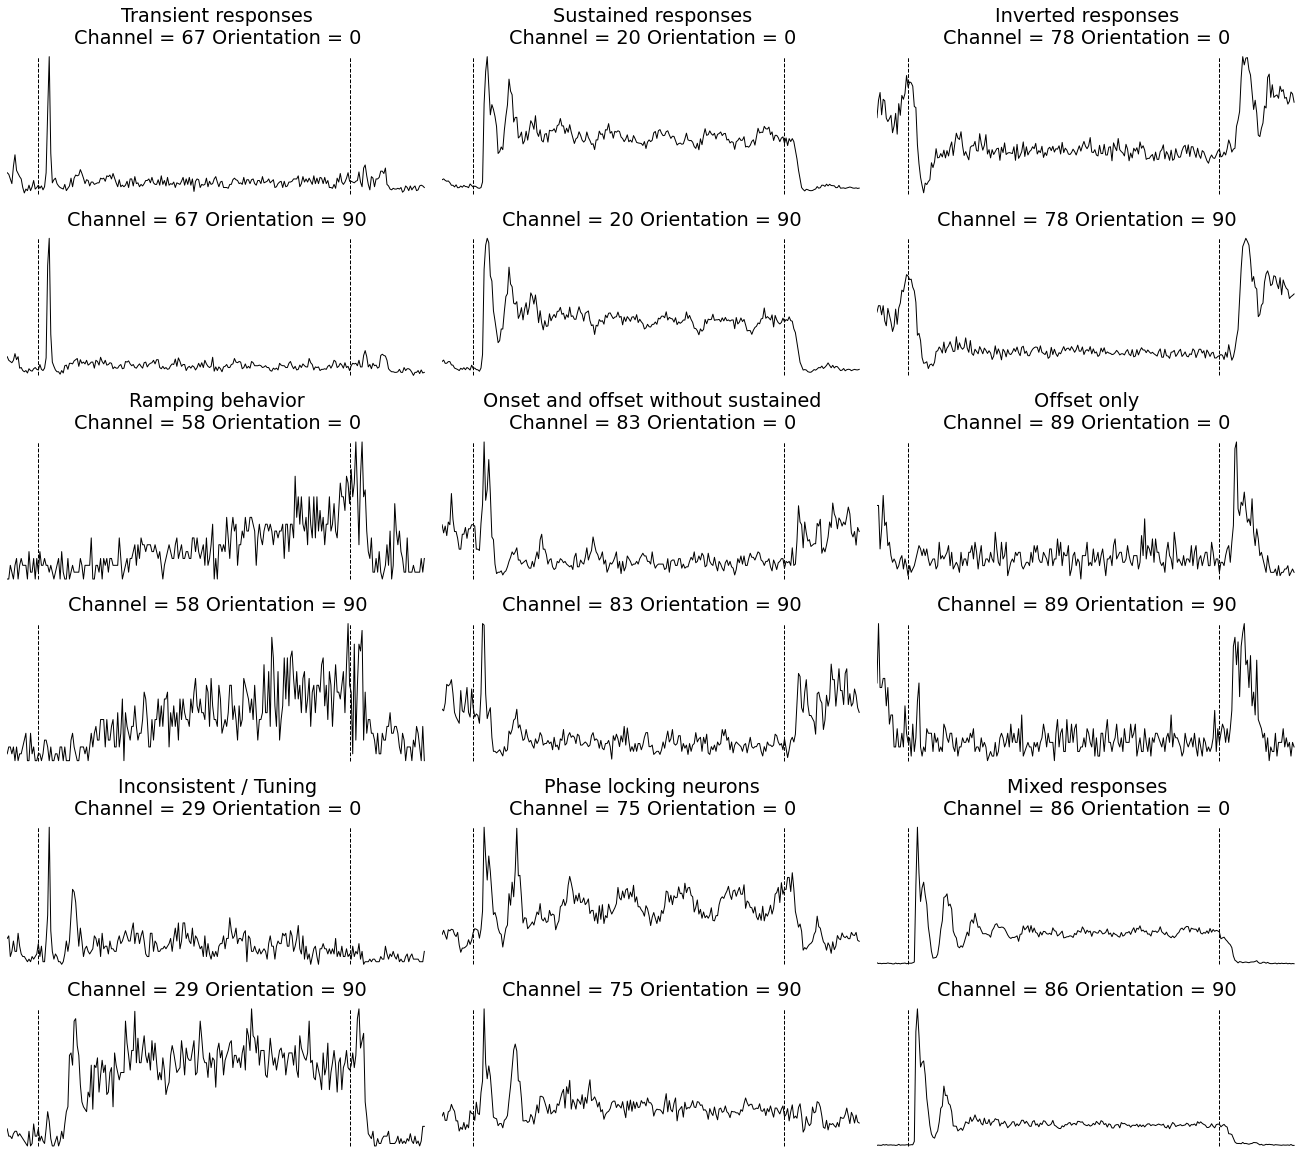

In [144]:
# Cell added by me to replicate figure 4.4 from book
fig, axes = plt.subplots(6,3, figsize=[18,16], constrained_layout=True)

for ax,unitkey,oo,subfigstring in zip([axes[0][0], axes[1][0], axes[0][1], axes[1][1], axes[0][2], axes[1][2], 
            axes[2][0], axes[3][0], axes[2][1], axes[3][1], axes[2][2], axes[3][2],
            axes[4][0], axes[5][0], axes[4][1], axes[5][1], axes[4][2], axes[5][2]],
            [67,67, 20,20, 78,78, 58,58, 83,83, 89,89, 29,29, 75,75, 86,86],
            [ 0,90,  0,90,  0,90,  0,90,  0,90,  0,90,  0,90,  0,90,  0,90],
            ['Transient responses','', 'Sustained responses','', 'Inverted responses','', 
            'Ramping behavior','', 'Onset and offset without sustained','', 'Offset only','', 
            'Inconsistent / Tuning','', 'Phase locking neurons','', 'Mixed responses','', ]):
    
    ax.plot(timeBase[:-1],PSTHs[unitkey][oo],lw=1,color='k')
    ax.set_xlim([-.2,2.5])
    ax.vlines(gratingOn,0,max(PSTHs[unitkey][oo]),color='k',linestyle='--', lw=1)
    ax.vlines(gratingOff,0,max(PSTHs[unitkey][oo]),color='k',linestyle='--', lw=1)
    if oo == 0:
        ax.set_title(subfigstring + '\n' + 'Channel = '+str(int(unitkey))+' Orientation = '+str(oo))
    else:
        ax.set_title('Channel = '+str(int(unitkey))+' Orientation = '+str(oo))
    ax.axis('off')
plt.show()
    

### Comparing two neurons:
![](images/ch4_7.png)
![](images/ch4_combined%20figures.png)

In [147]:
# Reject damaged electrodes

# Cell borrowed from publisher site: https://www.elsevier.com/books-and-journals/book-companion/9780128040430/chapter-files#Chapter%20Files

livePSTHs = PSTHs.copy() 
deadchannels = [21, 31, 34, 56, 68] 
[livePSTHs.pop(dead, None) for dead in deadchannels ] # Remove dead/damaged channels.
numChanLeft = len(livePSTHs) # Calculate remained number of channels

In [153]:
print(len(PSTHs), 'channels including damaged.')
print(numChanLeft, 'channels excluding damaged.')
# Seems dead channels were previously removed from dataset.

91 channels including damaged.
91 channels excluding damaged.


In [112]:
# Cell borrowed from publisher site: https://www.elsevier.com/books-and-journals/book-companion/9780128040430/chapter-files#Chapter%20Files

rSC = np.zeros(shape=(len(livePSTHs),len(livePSTHs),len(ori)))  # Matrix for spike count correlations
for rowind,rowkey in enumerate(livePSTHs.keys()):     # Loop over all row channels
    for colind,colkey in enumerate(livePSTHs.keys()): # Loop over all column channels
        for oind,oo in enumerate(ori):                # Loop over all orientations.
            rSC[rowind,colind,oind],dummy =sc.pearsonr(livePSTHs[rowkey][oo], livePSTHs[colkey][oo])
globalMean=np.mean(rSC) # Calculate mean correlation for this dataset

In [154]:
print('Mean correlation coef:', globalMean)

Mean correlation coef: 0.14627974945959554


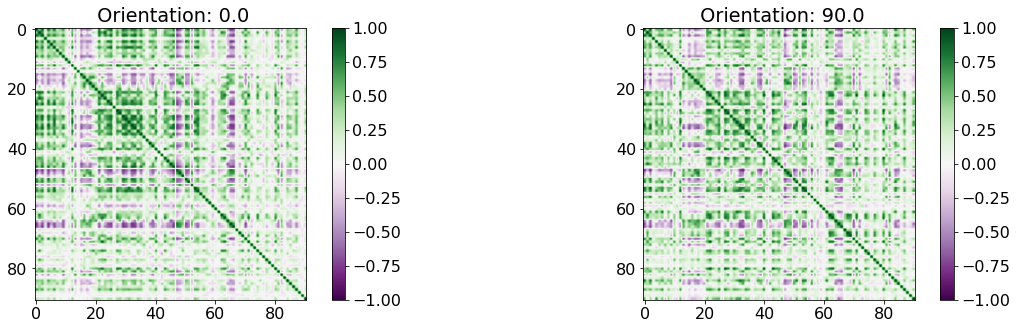

In [135]:
# Cell borrowed from publisher site: https://www.elsevier.com/books-and-journals/book-companion/9780128040430/chapter-files#Chapter%20Files

fig=plt.figure(figsize=(20,5)) #1
for orind,oo in enumerate(ori): #9
    ax=fig.add_subplot(1,2,orind+1) #2
    plt.imshow(rSC[:,:,orind],clim=(-1,1),cmap='PRGn') #3 #'RdYlBu'
    plt.colorbar() #6
    plt.title(' Orientation: '+str(oo)) #7
plt.show()

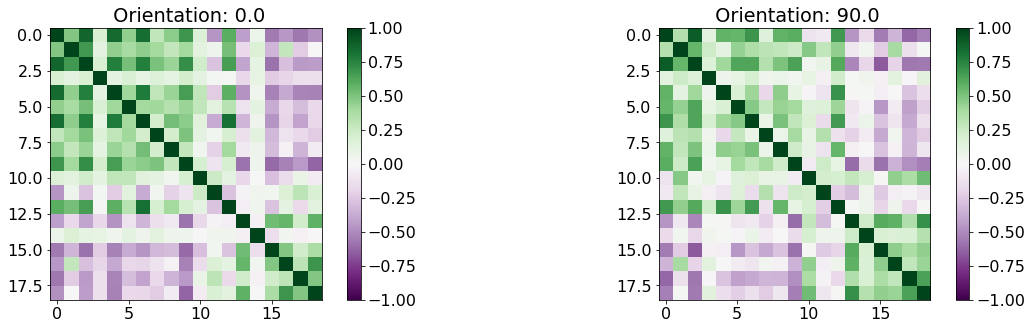

In [138]:
# Zooming in on first 19 neurons to show increasing spike responses and inverted (decreasing) responses
import matplotlib #0
%matplotlib inline
fig=plt.figure(figsize=(20,5)) #1
for orind,oo in enumerate(ori): #9
    matplotlib.rcParams.update({'font.size': 16}) #8
    ax=fig.add_subplot(1,2,orind+1) #2
    plt.imshow(rSC[:19,:19,orind],clim=(-1,1),cmap='PRGn') #3 
    plt.colorbar() #6
    plt.title(' Orientation: '+str(oo)) #7
plt.show()

### Other things can be done with these correlation matrices:
* Reject noisy channels
* Ignore spikes before onset and after offset
* Sort spikes by putative neurons instead of electrode channels (based on sort codes derived from unsupervised factor analysis)
  * This can be referred to as going from multiunit to single units.
* Convolve PSTHs before calculating correlations.

In [171]:
# Convolve PSTHs

kernel = np.ones(5)

convS = dict()
convT = dict()

for unitkey in PSTHs.keys():
    convS[unitkey] = dict()
    for oo in ori:
        convS[unitkey][oo] = np.convolve(PSTHs[unitkey][oo],kernel)
        convT = np.convolve(timeBase,kernel)


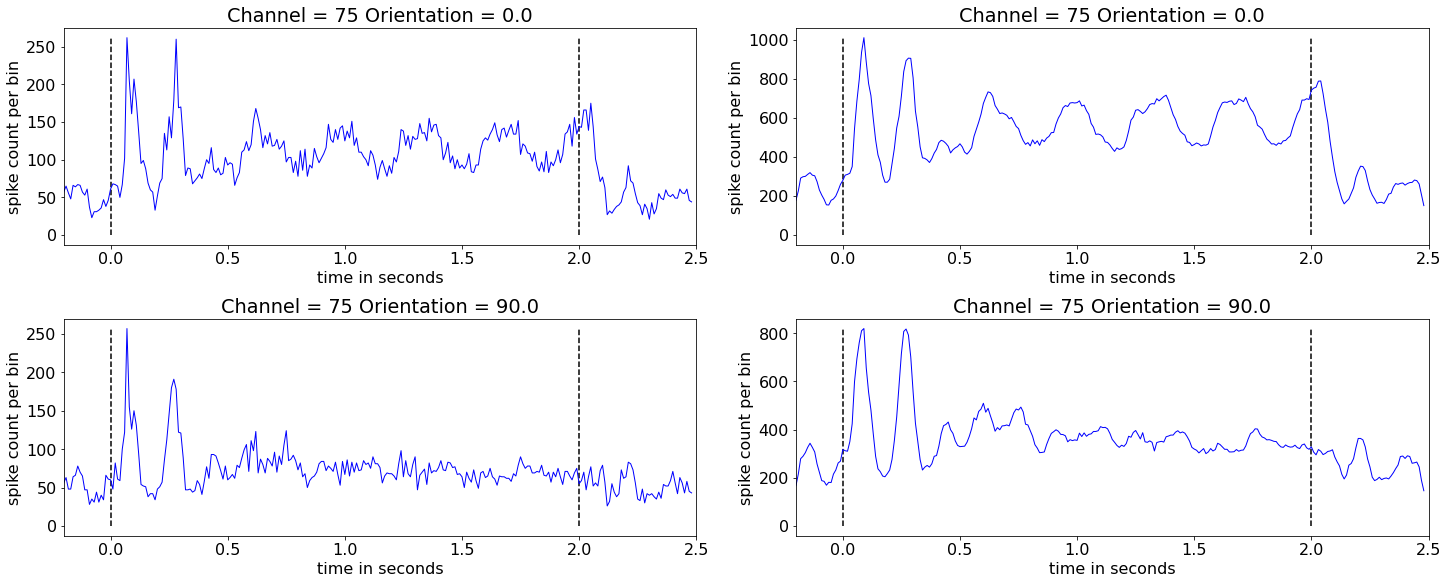

In [181]:
unitkey = 75

fig, axes = plt.subplots(2,2,figsize=[20, 8], constrained_layout=True)

for ax, oo in zip([axes[0,0], axes[1,0]], ori):
    ax.plot(timeBase[:-1],PSTHs[unitkey][oo],lw=1,color='b')
    ax.set_xlim([-.2,2.5])
    ax.vlines(gratingOn,0,max(PSTHs[unitkey][oo]),color='k',linestyle='--')
    ax.vlines(gratingOff,0,max(PSTHs[unitkey][oo]),color='k',linestyle='--')
    ax.set_ylabel('spike count per bin')
    ax.set_xlabel('time in seconds')
    ax.set_title('Channel = '+str(int(unitkey))+' Orientation = '+str(oo))

for ax, oo in zip([axes[0,1], axes[1,1]], ori):
    ax.plot(timeBase[:-1],convS[unitkey][oo][2:-2],lw=1,color='b')
    ax.set_xlim([-.2,2.5])
    ax.vlines(gratingOn,0,max(convS[unitkey][oo]),color='k',linestyle='--')
    ax.vlines(gratingOff,0,max(convS[unitkey][oo]),color='k',linestyle='--')
    ax.set_ylabel('spike count per bin')
    ax.set_xlabel('time in seconds')
    ax.set_title('Channel = '+str(int(unitkey))+' Orientation = '+str(oo))



# Start on Chapter 5 - Analog Signals

### Outline for today:
* Sin waves
* Fourier transform
* Spectrogram (short-form Fourier transform)

Text(0.5, 1.0, '2 Hz cos wave with no phase shift, or sin wave with 90 degree phase shift')

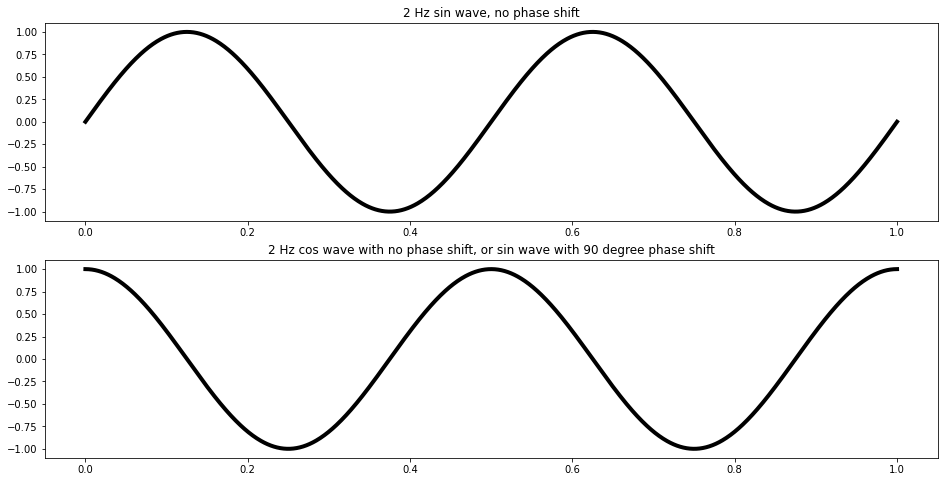

In [209]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 8)  ############
fig=plt.figure() #1
fs = 1000; #2
dur = 1; #3
t = np.linspace(0,dur,fs*dur); #4
freq = 2; #5
sinW = np.sin(2*np.pi*freq*t); #6
cosW = np.cos(2*np.pi*freq*t); #7
ax=plt.subplot(2,1,1) #8
ax.plot(t,sinW,c='k',lw=4) #9
ax.set_title('2 Hz sin wave, no phase shift')
ax=plt.subplot(2,1,2) #10
ax.plot(t,cosW,c='k',lw=4) #11
ax.set_title('2 Hz cos wave with no phase shift, or sin wave with 90 degree phase shift')

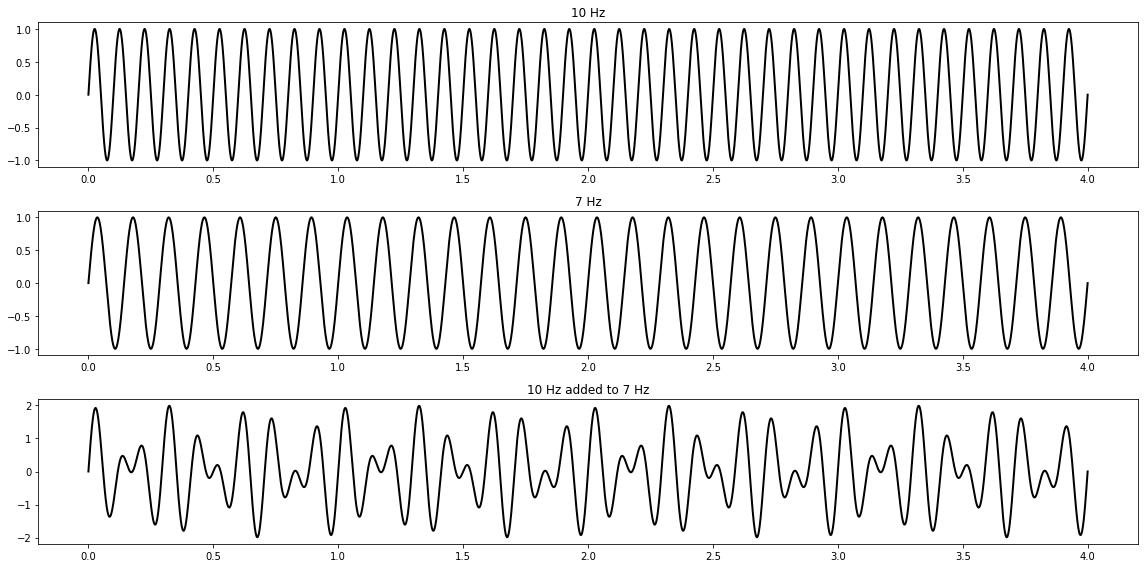

In [210]:
fig = plt.figure() #1
dur = 4 #2
t = np.linspace(0,dur,fs*dur) #3
freq = 10 #4
signal = np.sin(2*np.pi*freq*t) #5
ax = plt.subplot(3,1,1) #6
ax.plot(t,signal,c='k',lw=2) #7
ax.set_title(str(freq)+' Hz')

freq2 = 7; #1
signal2 = np.sin(2*np.pi*freq2*t); #2
ax=plt.subplot(3,1,2) #3
ax.plot(t,signal2,c='k',lw=2) #4
ax.set_title(str(freq2)+' Hz')
jointSignal = signal+signal2; #5
ax=plt.subplot(3,1,3) #6
ax.plot(t,jointSignal,c='k',lw=2) #7
ax.set_title(str(freq)+' Hz added to '+str(freq2)+' Hz')

plt.tight_layout()

c:\users\waltp\appdata\local\pypoetry\cache\virtualenvs\neuraldatascience-meetupseries-q80voz96-py3.9\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


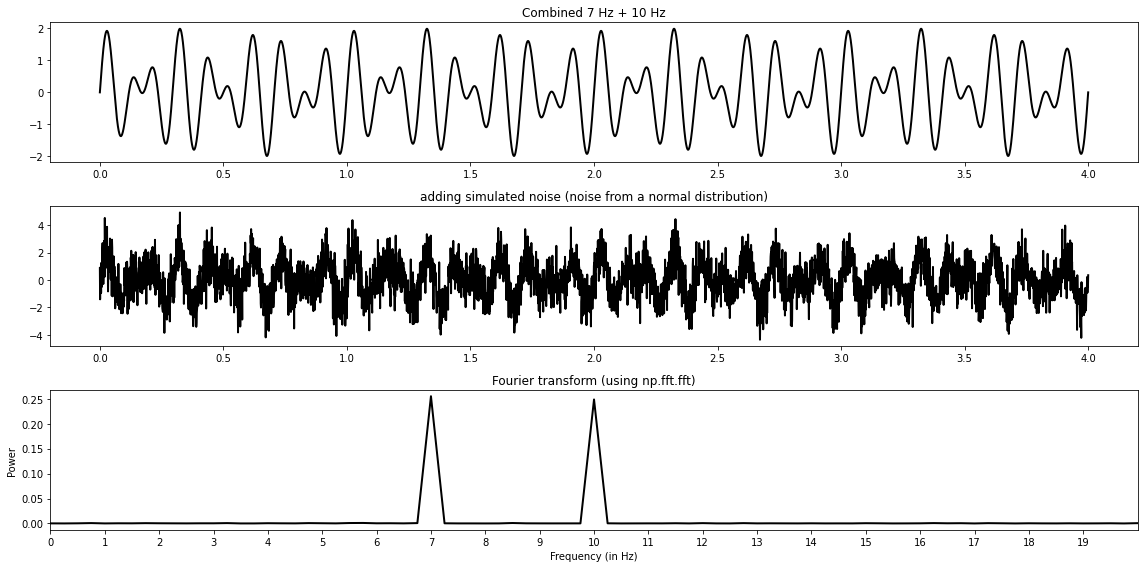

In [211]:
n = len(t) #1
noise = np.random.randn(n) #2
signalAndNoise = jointSignal + noise #3
fig = plt.figure() #4
ax = plt.subplot(3,1,1) #4
ax.plot(t,jointSignal,c='k',lw=2) #6
ax.set_title('Combined 7 Hz + 10 Hz')
ax = plt.subplot(3,1,2) #7
ax.plot(t,signalAndNoise,c='k',lw=2) #8
ax.set_title('adding simulated noise (noise from a normal distribution)')
nyquist = fs/2 #1
fSpaceSignal = np.fft.fft(signalAndNoise)/len(t) #2
fBase = np.linspace(0,nyquist,int(np.floor(len(signalAndNoise)/2)+1)) #3

powerPlot = plt.subplot(3,1,3) #4
halfTheSignal = fSpaceSignal[:len(fBase)] #5
complexConjugate = np.conj(halfTheSignal)#6
powe = halfTheSignal*complexConjugate#7
powerPlot.plot(fBase,powe, c='k',lw=2) #8
powerPlot.set_xlim([0, 20]); #9
powerPlot.set_xticks(range(20));#10
powerPlot.set_xlabel('Frequency (in Hz)') #11
powerPlot.set_ylabel('Power')

powerPlot.set_title('Fourier transform (using np.fft.fft)')

plt.tight_layout()

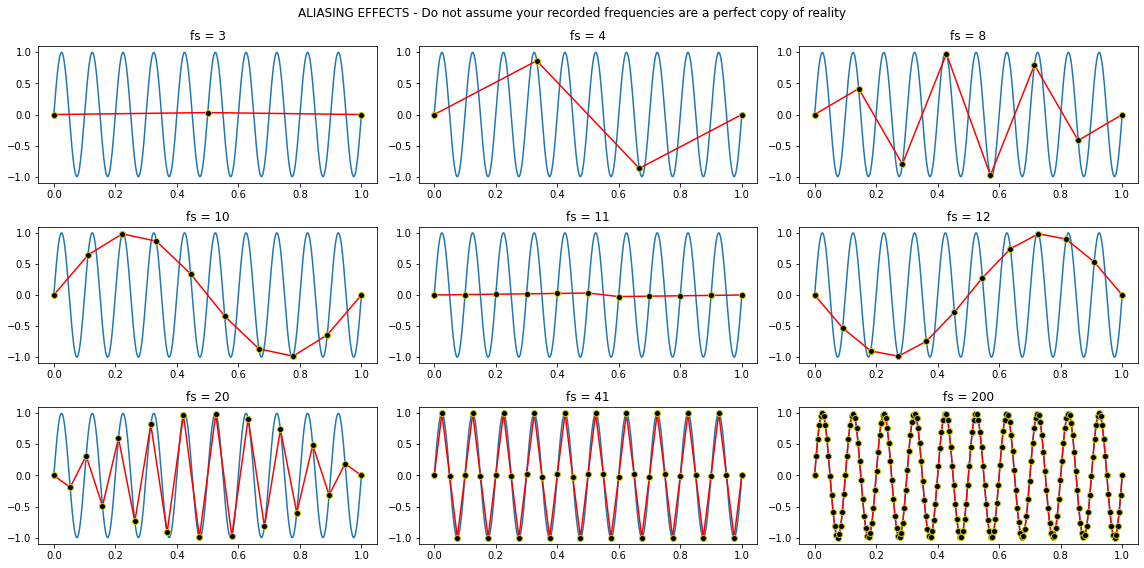

In [214]:
realSampling = 1000 #1
t = np.linspace(0,1,realSampling) #2
signalFrequency = 10 #3
samplingRate = [3, 4, 8, 10, 11, 12, 20, 41, 200] #4
signal = np.sin(2*np.pi*signalFrequency*t)#5
fig=plt.figure() #6
for ii,sampleRate in enumerate(samplingRate): #15
    ax = plt.subplot(3,3,ii+1)#7
    ax.plot(t,signal)#8
    sampledSignal = np.rint(np.linspace(0, len(t)-1, sampleRate)).astype(int)#10
    q = ax.plot(t[sampledSignal],signal[sampledSignal],c='r',marker='o',mfc='k',mec='y',
markersize=6); #11
    plt.title('fs = '+str(sampleRate)) #14
fig.suptitle('ALIASING EFFECTS - Do not assume your recorded frequencies are a perfect copy of reality')
plt.tight_layout()
plt.show()

<ipython-input-215-81682523bc6d>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(tt,f,Sxx,cmap='hot') #!4
<ipython-input-215-81682523bc6d>:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(tt,f,Sxx,cmap='hot') #14


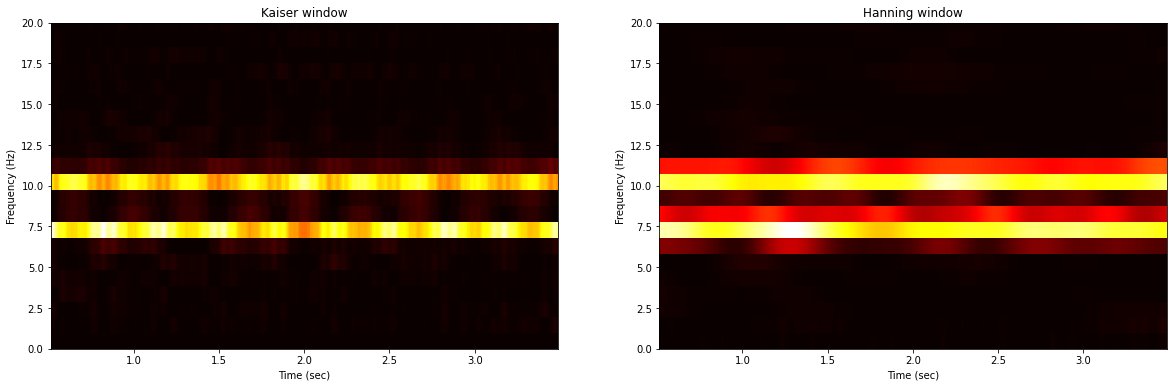

In [215]:
import scipy.signal as sg #13 
windLength = 1024; #1
wind = np.kaiser(windLength,0); #2
overl = len(wind)-1; #3
yFreqs = range(21); #4
fig = plt.figure(figsize=[20,6]) #5
plt.subplot(1,2,1) #6
f, tt, Sxx =sg.spectrogram(signalAndNoise,fs,wind,len(wind),overl) #7
plt.pcolormesh(tt,f,Sxx,cmap='hot') #!4
plt.ylabel('Frequency (Hz)');plt.xlabel('Time (sec)') #15 label axes
plt.ylim([0,20]) #16
plt.title('Kaiser window')
wind = np.hanning(windLength);#8
plt.subplot(1,2,2) #9
f, tt, Sxx =sg.spectrogram(signalAndNoise,fs,wind,len(wind),overl) #7
plt.pcolormesh(tt,f,Sxx,cmap='hot') #14
plt.ylabel('Frequency (Hz)');plt.xlabel('Time (sec)')#15 label axes
plt.ylim([0,20]) #16
plt.title('Hanning window')
plt.show()

# Intuitive examples: spectrograms and bird song
http://soundbirding.org/index.php/sound-and-spectrograms/